# Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU, Add, LeakyReLU,PReLU#, Sequential
from tensorflow.keras.models import save_model, load_model

In [3]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255

In [5]:
len(train_x)

50000

# Noise

In [6]:
noise = np.random.normal(loc=0.0, scale=0.1, size=train_x.shape)
train_x_noise = train_x + noise # tra
train_x_noise = np.clip(train_x_noise, 0., 1.)

In [7]:
noise = np.random.normal(loc=0.0, scale=0.1, size=test_x.shape)
test_x_noise = test_x + noise
test_x_noise = np.clip(test_x_noise, 0., 1.)

# Visualize

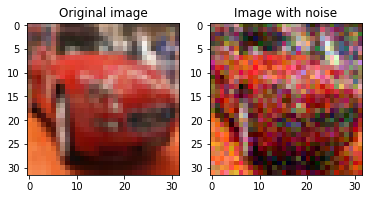

In [8]:
plt.subplot(1,2,1)
plt.imshow(train_x[5])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_x_noise[5])
plt.title('Image with noise')
plt.show()

# Model

In [9]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [10]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [11]:
def generator():
   den_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(den_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)
   den_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(den_inputs, den_outputs)

In [12]:
import tensorflow

In [13]:
#from keras.applications.inception_v3 import InceptionV3
#from keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


In [14]:
def discriminator():
  model = Sequential()
  base_layer = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
  model.add(base_layer)
  
  model.add(Flatten())
  model.add(Dropout(0.2)) 

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))  
    
  model.add(Dense(1024, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  #for layer in base_layer.layers[:-4]:
    #layer.trainable = False
  base_layer.trainable = False  
  return model

In [14]:
def discriminator():
  inputs1 = Input(shape=(32, 32, 3))
  
  b = Conv2D(64, (3, 3), padding='same', strides=1)(inputs1)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(6, (3, 3), padding='same', strides=2)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(128, (3, 3), padding='same', strides=1)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(128, (3, 3), padding='same', strides=2)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(256, (3, 3), padding='same', strides=1)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(256, (3, 3), padding='same', strides=2)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(512, (3, 3), padding='same', strides=1)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Conv2D(512, (3, 3), padding='same', strides=2)(b)
  b = BatchNormalization()(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Flatten()(b)

  b = Dense(1024)(b)
  b = LeakyReLU(alpha=0.1)(b)
  b = Dense(1,activation='sigmoid')(b)

  model2 = Model(inputs=inputs1, outputs=b)
  return model2



2 stage Approach, 1-st autoencoder, to teach denoising. 2nd GAN to fine tune

# Load Weights

In [15]:
disc_model = load_model("/content/drive/My Drive/denoising_disc_model_01.h5")

In [16]:
tot_model = load_model("/content/drive/My Drive/denoising_tot_model_01.h5")

In [17]:
gen_model = load_model("/content/drive/My Drive/denoising_gen_model_01.h5")

# Auto_Enc Pretrain

In [18]:
#gen_model = generator()

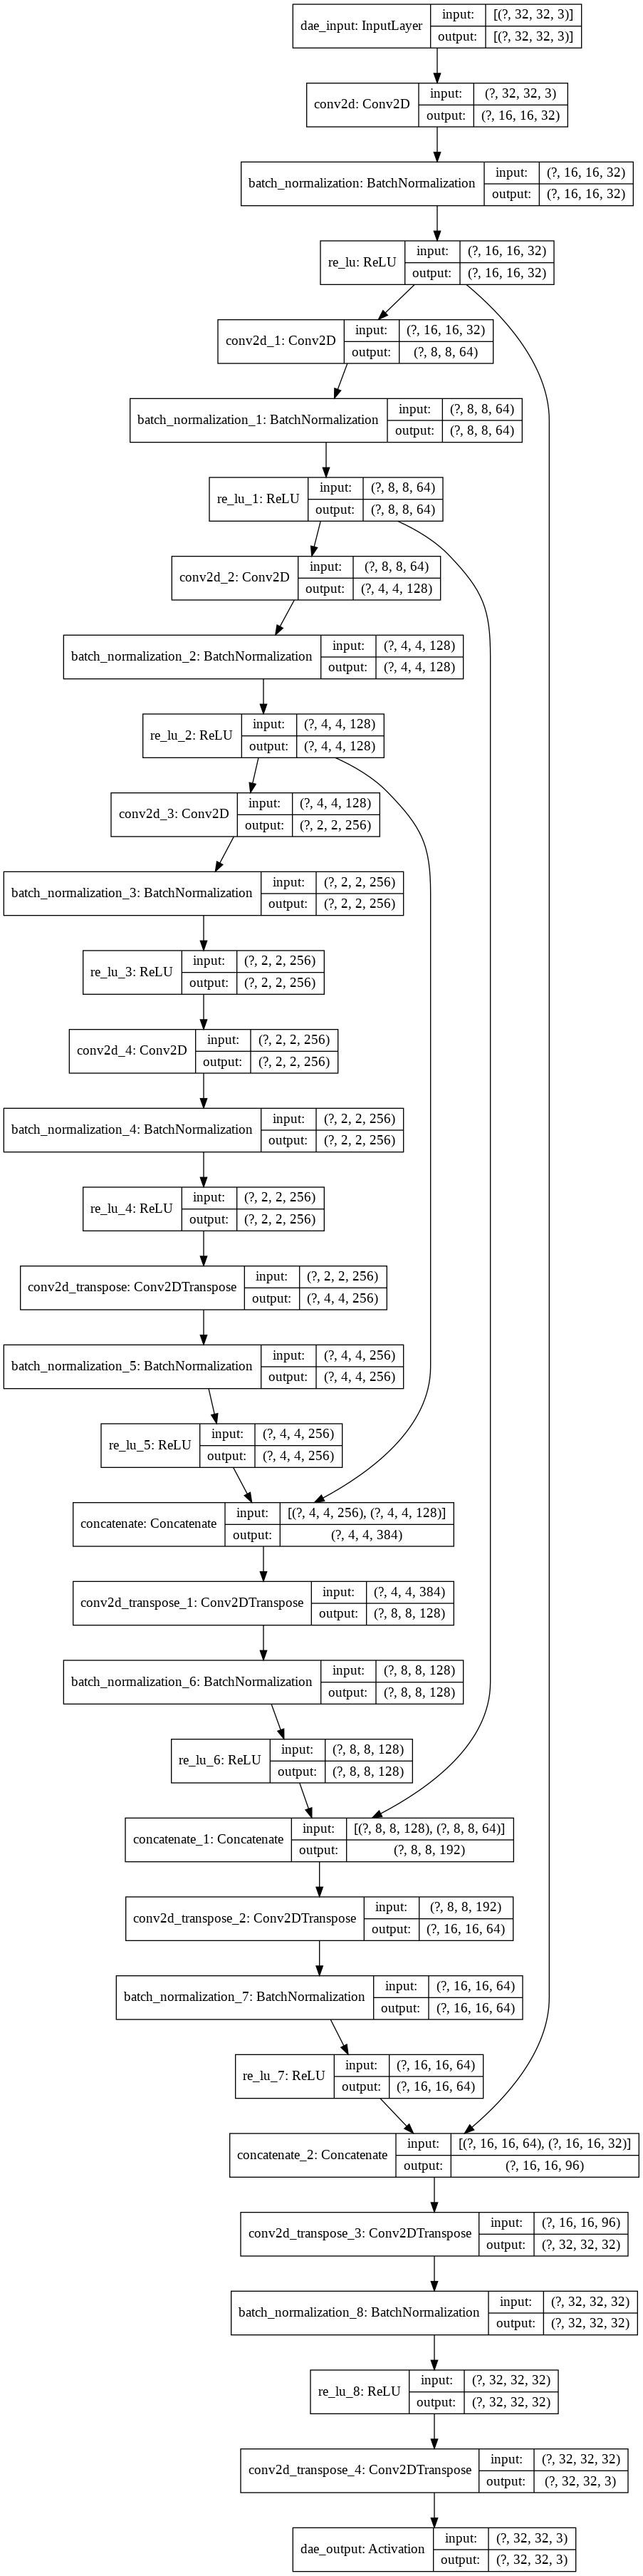

In [19]:
tensorflow.keras.utils.plot_model(gen_model, show_shapes=True)

In [20]:
gen_model.compile(loss='mse', optimizer='adam')
#gen_model.fit(train_x_noise,train_x,validation_data=(test_x_noise, test_x),epochs=8,batch_size=128)

# After Pre-Train

# Test

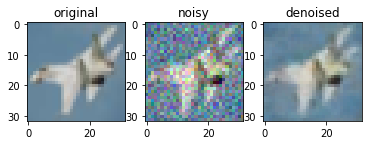

In [21]:
test_data_denoised = gen_model.predict(test_x_noise)
idx = 10
plt.subplot(1,3,1)
plt.imshow(test_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_x_noise[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

In [22]:
im1 = test_x[idx]
im2 = test_data_denoised[idx]
im1 = tensorflow.image.convert_image_dtype(test_x, tensorflow.float32)
im2 = tensorflow.image.convert_image_dtype(test_data_denoised, tensorflow.float32)
psnr1 = tensorflow.image.psnr(im1, im2, max_val=1)
psnr_avg = tensorflow.reduce_mean(psnr1)

In [23]:
print(psnr_avg)

tf.Tensor(27.918287, shape=(), dtype=float32)


# Train

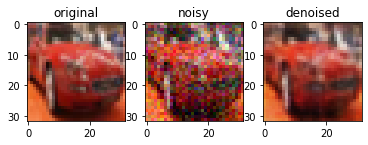

In [24]:
idx = 5
train_data_denoised = gen_model.predict(train_x_noise)

plt.subplot(1,3,1)
plt.imshow(train_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(train_x_noise[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(train_data_denoised[idx])
plt.title('denoised')
plt.show()

# PSNR

In [25]:
im1 = tensorflow.image.convert_image_dtype(train_x, tensorflow.float32)
im2 = tensorflow.image.convert_image_dtype(train_data_denoised, tensorflow.float32)
psnr2 = tensorflow.image.psnr(im1, im2, max_val=1)
psnr_avg2 = tensorflow.reduce_mean(psnr2)

In [26]:
print(psnr_avg2)

tf.Tensor(27.927826, shape=(), dtype=float32)


Between noisy

In [ ]:
im1 = tensorflow.image.convert_image_dtype(train_x, tensorflow.float32)
im2 = tensorflow.image.convert_image_dtype(train_x_noise, tensorflow.float32)
psnr2 = tensorflow.image.psnr(im1, im2, max_val=1)
psnr_avg2 = tensorflow.reduce_mean(psnr2)

In [ ]:
print(psnr_avg2)

# PSNR Method

In [27]:
def psnr_call(im1,im2):
  im1 = tensorflow.image.convert_image_dtype(im1, tensorflow.float32)
  im2 = tensorflow.image.convert_image_dtype(im2, tensorflow.float32)
  psnr2 = tensorflow.image.psnr(im1, im2, max_val=1)
  psnr_avg3 = tensorflow.reduce_mean(psnr2)
  return psnr_avg3

# GAN

In [28]:
#disc_model = discriminator()
disc_model.compile(loss='binary_crossentropy', optimizer='adam')

In [29]:
def combined_model(gen_model,disc_model):
  ip_layer = Input(shape=(32,32,3))
  disc_model.trainable = False
  gen_op = gen_model(ip_layer)
  disc_op = disc_model(gen_op)
  tot_model = Model(inputs=ip_layer, outputs=[gen_op, disc_op])
  adam_mod = Adam(learning_rate=0.0001)  
  tot_model.compile(loss=['mae', 'binary_crossentropy'], optimizer=adam_mod)
  return tot_model

In [30]:
tot_model = combined_model(gen_model,disc_model)

In [31]:
tot_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model (Model)                (None, 32, 32, 3)         2155139   
_________________________________________________________________
model_1 (Model)              (None, 1)                 6691487   
Total params: 8,846,626
Trainable params: 2,152,707
Non-trainable params: 6,693,919
_________________________________________________________________


In [32]:
import random

In [33]:
gen_labels = []
for gen in range(0,50000):
  gen_labels.append(0)

In [34]:
len(gen_labels)

50000

In [35]:
gen_list_im = []
for j in range(0,8):
  fake = []
  #real = []
  img = []
  labels = []
  history1 = []
  #history2 = []
  history3 = []
  randomlist1 = random.sample(range(0, 20000), 10000)
  for k in randomlist1:
    fake.append(train_x_noise[k])
    labels.append(0)
    

  rec = gen_model.predict(np.asarray(fake))
  for i in range(0,10000):
    img.append(rec[i])

  #print(len(img))


  randomlist2 = random.sample(range(0, 20000), 10000)
  for k in randomlist2:
    img.append(train_x[k])
    labels.append(1) 

  #print(len(img))

  # Generator Train
  print("Generator Train: ")
  #gen_model.trainable = True
  #disc_model.trainable = False
  
  tot_model.fit(train_x_noise,y=[train_x,np.asarray(gen_labels)],epochs=1,batch_size=128)
  #history1.append(h1)

  #h2 = gen_model.fit(train_x_noise,train_x,epochs=1,batch_size=128)
  #history2.append(h2)

  #reca = gen_model.predict(train_x_noise)
  
  print("PSNR Train Average: ",psnr_call(train_x,gen_model.predict(train_x_noise)))
  print("PSNR Test Average: ",psnr_call(test_x,gen_model.predict(test_x_noise)))

  #disp = gen_model.predict(train_x_noise[8:10])
  #gen_list_im.append(disp[1])

  # Discriminator Train
  print("Discriminator Train: ")
  #gen_model.trainable = False
  #disc_model.trainable = True
  disc_model.fit(np.asarray(img), np.asarray(labels),epochs=2,batch_size=64)
  #history3.append(h3)

Generator Train: 
391/391 [==============================] - 13s 33ms/step - loss: 0.0545 - model_loss: 0.0333 - model_1_loss: 0.0212
PSNR Train Average:  tf.Tensor(27.73311, shape=(), dtype=float32)
PSNR Test Average:  tf.Tensor(27.727097, shape=(), dtype=float32)
Discriminator Train: 
Epoch 1/2
313/313 [==============================] - 2s 6ms/step - loss: 3.7257
Epoch 2/2
313/313 [==============================] - 2s 6ms/step - loss: 3.7257
Generator Train: 
391/391 [==============================] - 13s 33ms/step - loss: 0.0330 - model_loss: 0.0330 - model_1_loss: 7.0446e-20
PSNR Train Average:  tf.Tensor(27.790495, shape=(), dtype=float32)
PSNR Test Average:  tf.Tensor(27.783794, shape=(), dtype=float32)
Discriminator Train: 
Epoch 1/2
313/313 [==============================] - 2s 6ms/step - loss: 0.0715
Epoch 2/2
313/313 [==============================] - 2s 6ms/step - loss: 0.0715
Generator Train: 
391/391 [==============================] - 13s 32ms/step - loss: 0.0328 - model_l

In [ ]:
plt.plot(history1)#, label='train')
#plt.plot(history2['model_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
h4.history['loss']

In [36]:
tot_model.save('/content/drive/My Drive/denoising_tot_model_02_ep8.h5')

In [37]:
disc_model.save("/content/drive/My Drive/denoising_disc_model_02_ep8.h5")

In [38]:
gen_model.save("/content/drive/My Drive/denoising_gen_model_02_ep8.h5")

In [ ]:
train_GAN = gen_model.predict(train_x_noise[8:10])
test_GAN = gen_model.predict(test_x_noise)

In [ ]:
idx = 8
plt.subplot(1,3,1)
plt.imshow(test_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.subplot(1,3,3)
plt.imshow(test_GAN[idx])
plt.title('GAN Result')
plt.show()

In [ ]:
plt.imshow(train_x[5])

In [ ]:
idx = 0
plt.subplot(1,3,1)
plt.imshow(train_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(train_data_denoised[idx])
plt.title('denoised')
plt.subplot(1,3,3)
plt.imshow(train_GAN[idx])
plt.title('GAN Result')
plt.show()

In [ ]:
plt.imshow(gen_list_im[2])

In [ ]:
im1 = test_x[idx]
im2 = test_data_denoised[idx]
im3 = test_GAN[idx]

im1 = tensorflow.image.convert_image_dtype(im1, tensorflow.float32)
im2 = tensorflow.image.convert_image_dtype(im2, tensorflow.float32)
psnr2 = tensorflow.image.psnr(im1, im2, max_val=1)

In [ ]:
im1 = tensorflow.image.convert_image_dtype(im1, tensorflow.float32)
im2 = tensorflow.image.convert_image_dtype(im3, tensorflow.float32)
psnr2 = tensorflow.image.psnr(im1, im2, max_val=1)

In [ ]:
print(psnr2)

**Ideas- Monitor and work on each losses. Also gen and disc models independently.**
eg - use lower LR for Generator 1st loss(High Values)